In [245]:
import os
import cv2

In [246]:
synthetic_data = "ThisPersonDoesNotExist"
real_data_dir = "thumbnails128x128"

In [247]:
synthetic_data_files = []
for dir in os.listdir(synthetic_data):
    synthetic_data_files.extend([os.path.join(synthetic_data, dir, f) for f in os.listdir(os.path.join(synthetic_data, dir))])

real_data_files = [os.path.join(real_data_dir, f) for f in os.listdir(real_data_dir)]

print("Synthetic data files: ", len(synthetic_data_files))
print("Real data files: ", len(real_data_files))

Synthetic data files:  6873
Real data files:  70001


In [248]:
from matplotlib import pyplot as plt

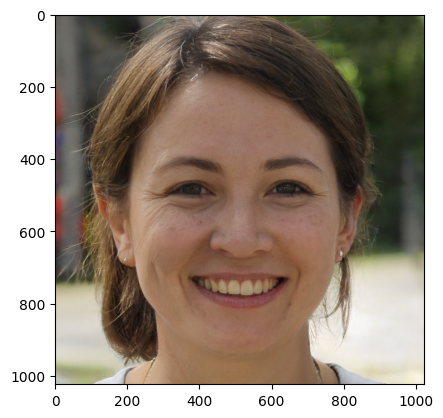

In [249]:
# Display the first synthetic image
img = cv2.imread(synthetic_data_files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

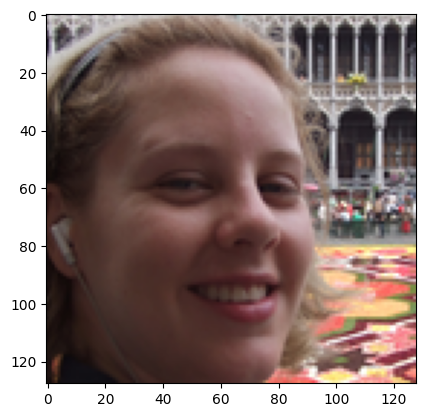

In [250]:
# Display the first real image
img = cv2.imread(real_data_files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [251]:
img = cv2.imread(synthetic_data_files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

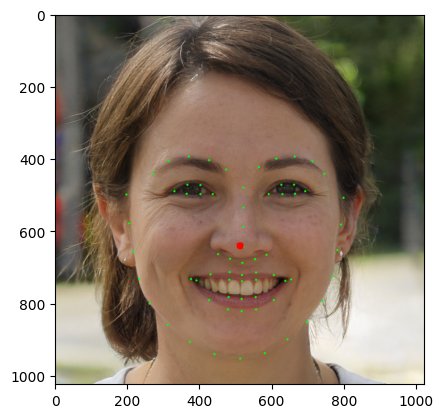

In [252]:
import cv2
import dlib

# Load the detector
detector = dlib.get_frontal_face_detector()

# Load the predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Use detector to find faces
faces = detector(img)

for face in faces:
    x1 = face.left()  # left point
    y1 = face.top()  # top point
    x2 = face.right()  # right point
    y2 = face.bottom()  # bottom point

    # Create landmark object
    landmarks = predictor(image=img, box=face)

    # Loop through all the points
    avg_x = 0
    avg_y = 0
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        avg_x += x
        avg_y += y

        # Draw a circle
        cv2.circle(img=img, center=(x, y), radius=3, color=(0, 255, 0), thickness=-1)
    avg_x /= 68
    avg_y /= 68
    cv2.circle(img=img, center=(int(avg_x), int(avg_y)), radius=10, color=(255, 0, 0), thickness=-1)

plt.imshow(img)

In [253]:
img = cv2.imread(real_data_files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

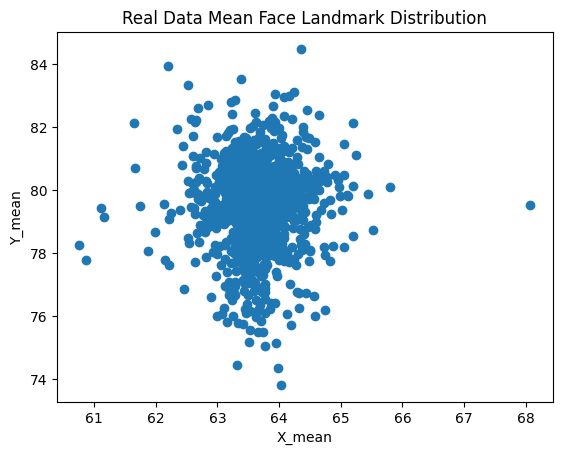

In [254]:
import cv2
import dlib

# Load the detector
detector = dlib.get_frontal_face_detector()

# Load the predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

real_faces_landmark_means = []

for img in real_data_files[:1000]:
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Use detector to find faces
    faces = detector(img)

    for face in faces:
        x1 = face.left()  # left point
        y1 = face.top()  # top point
        x2 = face.right()  # right point
        y2 = face.bottom()  # bottom point

        # Create landmark object
        landmarks = predictor(image=img, box=face)

        # Loop through all the points
        avg_x = 0
        avg_y = 0
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            avg_x += x
            avg_y += y

            # Draw a circle
            # cv2.circle(img=img, center=(x, y), radius=1, color=(0, 255, 0), thickness=-1)
        avg_x /= 68
        avg_y /= 68
        # cv2.circle(img=img, center=(int(avg_x), int(avg_y)), radius=2, color=(255, 0, 0), thickness=-1)

        real_faces_landmark_means.append((avg_x, avg_y))

# plot the real faces landmark means
import numpy as np
real_faces_landmark_means = np.array(real_faces_landmark_means)
plt.scatter(real_faces_landmark_means[:, 0], real_faces_landmark_means[:, 1])
plt.title("Real Data Mean Face Landmark Distribution")
plt.xlabel("X_mean")
plt.ylabel("Y_mean")
plt.show()

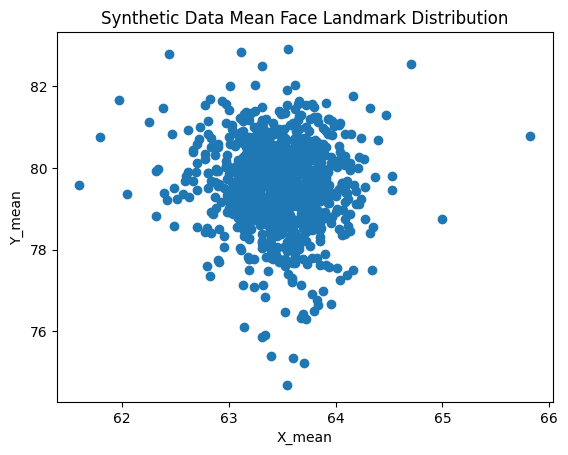

In [255]:
import cv2
import dlib

# Load the detector
detector = dlib.get_frontal_face_detector()

# Load the predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

real_faces_landmark_means = []

for img in synthetic_data_files[:1000]:
    img = cv2.imread(img)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Use detector to find faces
    faces = detector(img)

    for face in faces:
        x1 = face.left()  # left point
        y1 = face.top()  # top point
        x2 = face.right()  # right point
        y2 = face.bottom()  # bottom point

        # Create landmark object
        landmarks = predictor(image=img, box=face)

        # Loop through all the points
        avg_x = 0
        avg_y = 0
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            avg_x += x
            avg_y += y

            # Draw a circle
            # cv2.circle(img=img, center=(x, y), radius=1, color=(0, 255, 0), thickness=-1)
        avg_x /= 68
        avg_y /= 68
        # cv2.circle(img=img, center=(int(avg_x), int(avg_y)), radius=2, color=(255, 0, 0), thickness=-1)

        real_faces_landmark_means.append((avg_x, avg_y))

# plot the real faces landmark means
import numpy as np
real_faces_landmark_means = np.array(real_faces_landmark_means)
plt.scatter(real_faces_landmark_means[:, 0], real_faces_landmark_means[:, 1])
plt.title("Synthetic Data Mean Face Landmark Distribution")
plt.xlabel("X_mean")
plt.ylabel("Y_mean")
plt.show()

In [256]:
class FaceSample:
    def __init__(self, x_mean, y_mean, file_path):
        self.x_mean = x_mean
        self.y_mean = y_mean
        self.file_path = file_path

num_real_samples = len(synthetic_data_files)
real_sample_mean_face = []

for idx, img in enumerate(real_data_files):
    try:
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Use detector to find faces
        faces = detector(img)
    except:
        print("Error in file: ", real_data_files[idx])
        continue


    for face in faces:
        x1 = face.left()  # left point
        y1 = face.top()  # top point
        x2 = face.right()  # right point
        y2 = face.bottom()  # bottom point

        # Create landmark object
        landmarks = predictor(image=img, box=face)

        # Loop through all the points
        avg_x = 0
        avg_y = 0
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            avg_x += x
            avg_y += y

            # Draw a circle
            # cv2.circle(img=img, center=(x, y), radius=1, color=(0, 255, 0), thickness=-1)
        avg_x /= 68
        avg_y /= 68
        # cv2.circle(img=img, center=(int(avg_x), int(avg_y)), radius=2, color=(255, 0, 0), thickness=-1)

        real_sample_mean_face.append(FaceSample(avg_x, avg_y, real_data_files[idx]))

# sort the real_sample_mean_face by distance to 63.5, 80
real_sample_mean_face = sorted(real_sample_mean_face, key=lambda x: np.sqrt((x.x_mean - 63.5) ** 2 + (x.y_mean - 80) ** 2))
# sample len(synthetic_data_files) samples
real_sample_mean_face = real_sample_mean_face[:num_real_samples]

Error in file:  thumbnails128x128/LICENSE.txt


In [257]:
print(real_sample_mean_face[0].file_path)

thumbnails128x128/20640.png


In [258]:
# write the filenames to a json file
import json
with open("real_faces_subset.json", "w") as f:
    files = {"files": [x.file_path for x in real_sample_mean_face]}
    json.dump(files, f, indent=4)

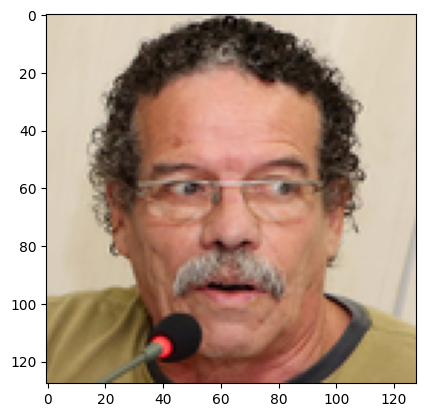

In [262]:
img = cv2.imread(real_sample_mean_face[0].file_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)